In [1]:
library(tidyverse)
library(networkD3)
library(htmlwidgets)
library(RColorBrewer)
library(ggrepel)
# library(ggthemes)
library(cowplot)
library(ggplotify)
library(ggforce)
library(ggalluvial)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'htmlwidgets'


The following object is masked from 'package:networkD3':

    JS




In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
project <- c("CESC", "UCS", "UCEC")
dset_paths <- unlist(map(dsets, function(d) paste0(dirs$data_dir, "/", d)))
matrisome_list <- matrisome_list <- paste(dirs$data_dir, "matrisome", "matrisome_hs_masterlist.tsv", sep = "/")

In [3]:
dset_idx <- 2

In [4]:
text_size <- 8
guide_size <- 4
family <- "ArialMT"
dpi <- 320
vp_ht <- 3
vp_wd <- 5
pt_to_mm <- 5 / 14

# Functions

In [5]:
de_color_scale <- c("Not sig." = "gray30", "Up" = "firebrick3", "Down" = "steelblue3")
to_vplot_df <- function(df, qval_thresh = 0.05, log2_fc_thresh = log2(2)) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_qval = -log10(qval)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_qval, qval, pvalue) %>%
        dplyr::mutate(DE = case_when(
            (qval < qval_thresh) & (log2_fc > log2_fc_thresh) ~ "Up",
            (qval < qval_thresh) & (log2_fc < -log2_fc_thresh) ~ "Down",
            TRUE ~ "Not sig."
        ))
    return(vplot_df)
}


make_vplot <- function(df, point_size = 0.25, hide_legend = TRUE, qval = 1e-10, neg_log10_qval_outlier_thresh = 100) {    

    plt <- ggplot(data = df %>% dplyr::filter(neg_log10_qval < neg_log10_qval_outlier_thresh)) +
        geom_point(aes(y = neg_log10_qval, x = log2_fc, color = DE), size = point_size) +
#         scale_color_manual(name = "DE", values = de_color_scale) +
        scale_color_manual(name = NULL, values = de_color_scale) +
        guides(color = guide_legend(override.aes = list(size = guide_size))) +
        labs(
            y = bquote(paste(-log[10], "(", italic(q), "-val)")),
            x = bquote(paste(log[2], " fold-change"))
        ) +
        theme_classic() +
        theme(
            text = element_text(size = text_size, family = family),
#             legend.title = element_blank(),
        )

    return(plt)
}

# Load data

In [6]:
dge_res_df <- read_tsv(paste0(dirs$analysis_dir, "/deg/", dsets[dset_idx], "_DESeq_results.tsv"))
counts_df <- read_tsv(paste0(dirs$data_dir, "/", dsets[dset_idx], "/counts.tsv")) %>%
    dplyr::rename("geneID" = "Hugo_Symbol") %>%
    dplyr::select(-"Entrez_Gene_Id")
matrisome_df <- rutils::load_matrisome_df(matrisome_list)


-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Hugo_Symbol = col_character()
)
i Use `spec()` for the full column specifications.



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_cha

In [7]:
genes_in_dset <- counts_df$geneID
matrisome_summary_df <- matrisome_df %>%
    # Which matrisome genes were in the dataset?
    mutate(
        in_unified_dataset = dplyr::case_when(
            gene_symbol %in% genes_in_dset ~ TRUE,
            !(gene_symbol %in% genes_in_dset) ~ FALSE
        )
    ) %>%
    # Which matrisome genes were lowly expressed?
    left_join(dge_res_df, by = c("gene_symbol" = "geneID"), keep = TRUE) %>%
    mutate(lowly_expressed = is.na(geneID)) %>%
    dplyr::select(-geneID) %>%
    dplyr::select(gene_symbol, in_unified_dataset, lowly_expressed, everything()) %>%
    dplyr::rename(geneID = gene_symbol)

# Volcano plots

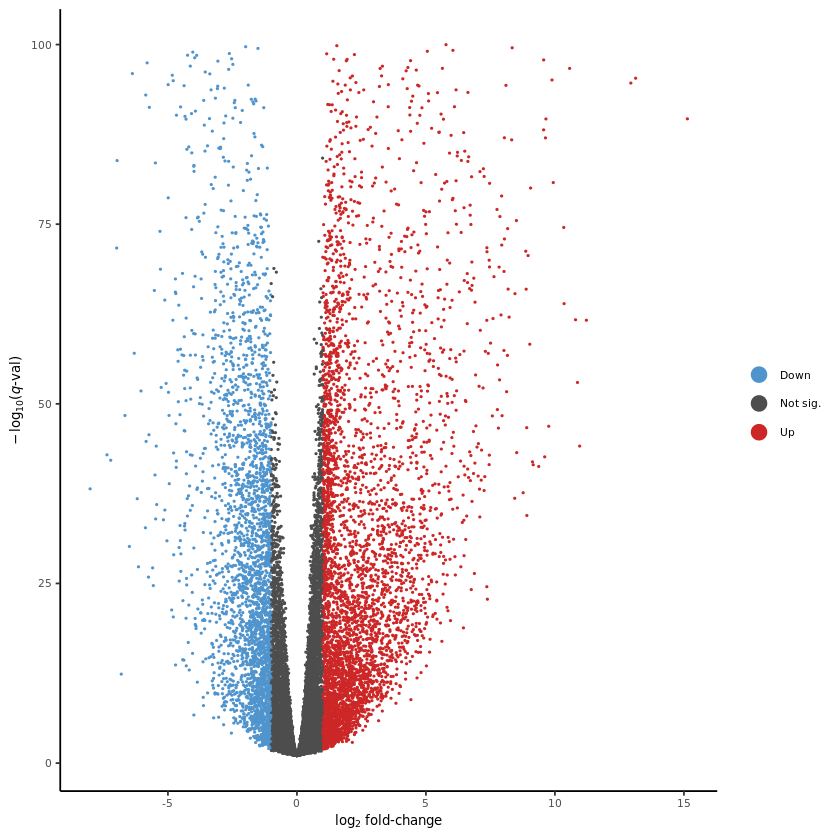

In [8]:
dge_res_df %>%
    to_vplot_df() %>%
    make_vplot()
all_gene_vplot <- last_plot()
ggsave(paste0(dirs$figures_dir, "/deg/", dsets[dset_idx], "_all_genes_vplot.png"), all_gene_vplot, height = vp_ht, width = vp_wd, dpi = dpi)

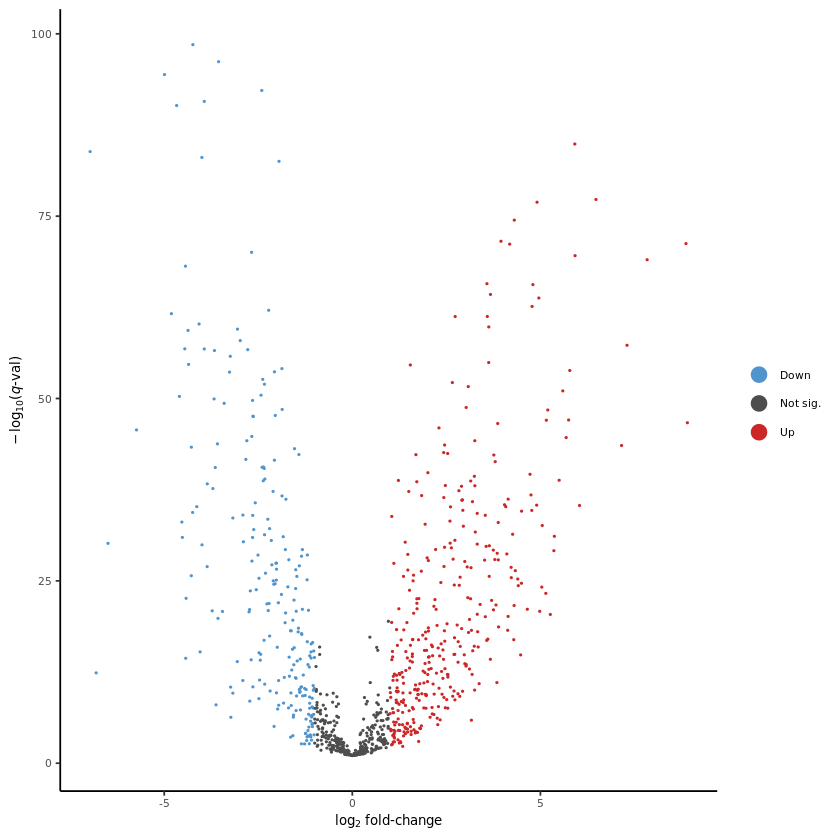

In [9]:
matrisome_summary_df %>%
    to_vplot_df() %>%
    make_vplot()
mat_gene_vplot <- last_plot()
ggsave(paste0(dirs$figures_dir, "/deg/", dsets[dset_idx], "_matrisome_genes_vplot.png"), mat_gene_vplot, height = vp_ht, width = vp_wd, dpi = dpi)

In [10]:
# save(all_gene_vplot, mat_gene_vplot, file = paste0(dirs$figures_dir, "/saved_obj/", dsets[dset_idx], "_vplots.RData"))
assign(paste0(project[dset_idx], "_all_gene_vplot"), all_gene_vplot)
assign(paste0(project[dset_idx], "_mat_gene_vplot"), mat_gene_vplot)
save(
    list = c(paste0(project[dset_idx], "_all_gene_vplot"), paste0(project[dset_idx], "_mat_gene_vplot")),
    file = paste0(dirs$figures_dir, "/saved_obj/", dsets[dset_idx], "_vplots.RData")
)


# Stacked barplots

In [11]:
matrisome_category_levels <- c("Proteoglycans", "Collagens", "ECM-affiliated Proteins", "ECM Glycoproteins", "ECM Regulators", "Secreted Factors")
matrisome_deseq_df <- matrisome_df %>%
    rename(geneID = gene_symbol) %>%
    filter(geneID %in% genes_in_dset) %>%
#     inner_join(dge_res_df, by = "geneID") %>%
    left_join(dge_res_df, by = "geneID") %>%
    rename(lfc = log2FoldChange, base_mean = baseMean) %>%
    select(geneID, division, category, base_mean, lfc, qval, pvalue) %>%
    mutate(
        de_category = case_when(
            lfc > log2(2) & qval < 0.05 ~ "Up",
            lfc < -log2(2) & qval < 0.05 ~ "Down",
            TRUE ~ "Not sig."
        ),
        de_category = factor(de_category, levels = c("Down", "Up", "Not sig.")),
        category = factor(category, levels = matrisome_category_levels)
    )

In [12]:
bp_md_df <- matrisome_deseq_df %>%
    group_by(category, de_category) %>%
    summarize(de_counts = n()) %>%
    group_by(category) %>%
    mutate(cat_counts = sum(de_counts)) %>%
    ungroup()
#     mutate(de_counts_pct = de_counts / cat_counts * 100)

`summarise()` has grouped output by 'category'. You can override using the `.groups` argument.



In [13]:
bp_md_df

category,de_category,de_counts,cat_counts
<fct>,<fct>,<int>,<int>
Proteoglycans,Down,12,35
Proteoglycans,Up,14,35
Proteoglycans,Not sig.,9,35
Collagens,Down,10,43
Collagens,Up,22,43
Collagens,Not sig.,11,43
ECM-affiliated Proteins,Down,31,168
ECM-affiliated Proteins,Up,53,168
ECM-affiliated Proteins,Not sig.,84,168


In [14]:
sum(bp_md_df$de_counts)

[1] 1008

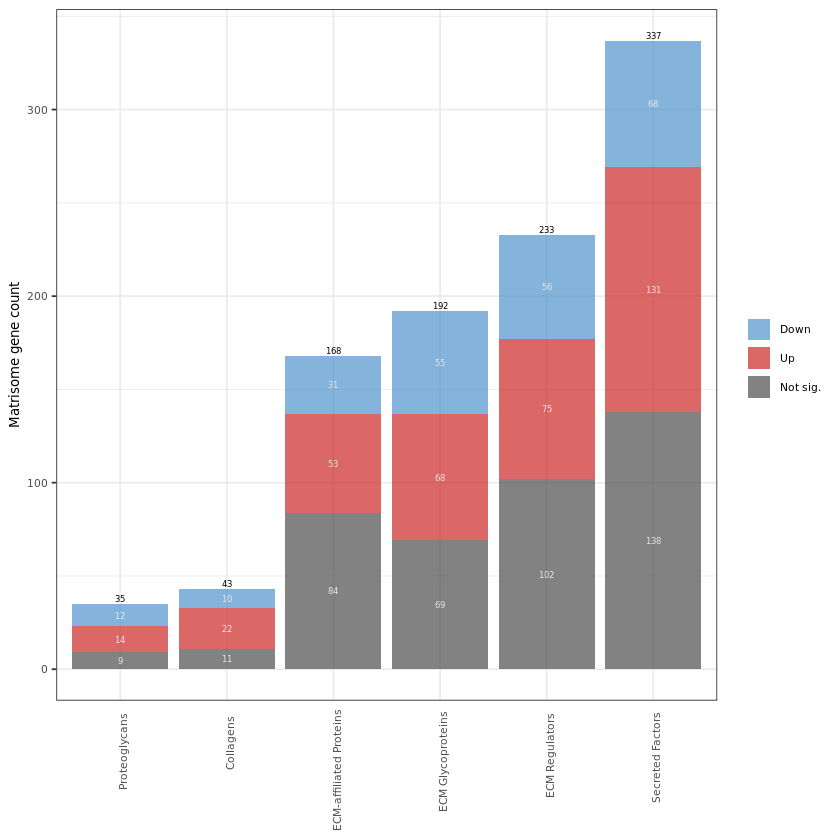

In [15]:
ggplot(data = bp_md_df, aes(fill = de_category, y = de_counts, x = category)) +
    geom_bar(position = "stack", stat = "identity", alpha = 0.7) +
    geom_text(aes(label = de_counts), position = position_stack(vjust = 0.5), color = "gray90", size = (text_size - 3) * pt_to_mm) +
    stat_summary(fun = sum, aes(label = ..y.., group = category), geom = "text", vjust = -0.25, size = (text_size - 3) * pt_to_mm) +
#     geom_text(aes(label = cat_counts), color = "gray0") +
    scale_fill_manual(values = de_color_scale, name = NULL) +
    guides(fill = guide_legend(override.aes = list(size = guide_size))) +
    theme_bw() +
    theme(
        text = element_text(size = text_size, family = family),
        axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.9, hjust = 0.9),
        axis.title.x = element_blank()
    ) +
    labs(y = "Matrisome gene count")

In [16]:
category_bplot <- last_plot()

In [17]:
assign(paste0(project[dset_idx], "_mat_de_bplot"), category_bplot)
save(
    list = c(paste0(project[dset_idx], "_mat_de_bplot")),
    file = paste0(dirs$figures_dir, "/saved_obj/", dsets[dset_idx], "_mat_de_bplots.RData")
)